In [ ]:
# Install the Kaggle package.
!pip install -q kaggle

# Upload your kaggle.json file (from your Kaggle account)
from google.colab import files
print("Please upload your kaggle.json file:")
files.upload()  # After running, select your kaggle.json file from your computer

# Create the required folder and move kaggle.json there with proper permissions.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [ ]:
# Download the dataset from Kaggle.
!kaggle datasets download -d trainingdatapro/roads-segmentation-dataset

# Unzip the dataset into a folder named "dataset"
!unzip -q roads-segmentation-dataset.zip -d dataset

# Optional: List directories to verify the structure.
!find dataset -type d -maxdepth=2


Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/roads-segmentation-dataset
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 56% 9.00M/16.0M [00:00<00:00, 87.9MB/s]
100% 16.0M/16.0M [00:00<00:00, 121MB/s] 
find: unknown predicate `-maxdepth=2'


# New model beacous overfitting


In [ ]:
# Install segmentation models library for PyTorch
!pip install -q segmentation-models-pytorch
!pip install -q albumentations

# Import essential libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torchsummary import summary


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
IMAGE_DIR = "dataset/images"
MASK_DIR = "dataset/masks"

image_paths = sorted([os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)])
mask_paths = sorted([os.path.join(MASK_DIR, f) for f in os.listdir(MASK_DIR)])

data = pd.DataFrame({'Image': image_paths, 'Mask': mask_paths})
print("Total Samples:", len(data))
data.head()


Total Samples: 31


,Image,Mask
0,dataset/images/0.png,dataset/masks/0.png
1,dataset/images/1.png,dataset/masks/1.png
2,dataset/images/10.png,dataset/masks/10.png
3,dataset/images/11.png,dataset/masks/11.png
4,dataset/images/12.png,dataset/masks/12.png


In [20]:
SEED = 42
train_data, rest_data = train_test_split(data, test_size=0.3, random_state=SEED)
val_data, test_data = train_test_split(rest_data, test_size=0.5, random_state=SEED)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 21, Val: 5, Test: 5


In [21]:
color2id = {
    (184, 61, 245): 0,  # Background
    (255, 53, 94): 1,   # Road sign
    (255, 204, 51): 2,  # Car
    (221, 255, 51): 3,  # Marking
    (61, 61, 245): 4    # Road surface
}

# Convert RGB masks to class indices
def mapping_color(mask: Image, color2id: dict):
    mask_np = np.array(mask)
    h, w, _ = mask_np.shape
    output = np.full((h, w), -1, dtype=np.int32)

    for color, idx in color2id.items():
        mask_area = np.all(mask_np == np.array(color), axis=-1)
        output[mask_area] = idx

    return output


In [22]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, data, color2id, transforms):
        self.data = data
        self.color2id = color2id
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]["Image"]
        mask_path = self.data.iloc[idx]["Mask"]

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))

        mask = mapping_color(mask, self.color2id)

        augmented = self.transforms(image=image, mask=mask)
        return augmented["image"], augmented["mask"]


In [23]:
RESIZE = (512, 512)

train_transforms = A.Compose([
    A.Resize(*RESIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(*RESIZE),
    A.Normalize(),
    ToTensorV2()
])

# Create datasets
train_dataset = RoadSegmentationDataset(train_data, color2id, train_transforms)
val_dataset = RoadSegmentationDataset(val_data, color2id, val_transforms)


In [24]:
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

# Check a sample batch
batch_images, batch_masks = next(iter(train_dataloader))
print("Image Shape:", batch_images.shape, "Mask Shape:", batch_masks.shape)


Image Shape: torch.Size([8, 3, 512, 512]) Mask Shape: torch.Size([8, 512, 512])


In [27]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define U-Net model with pretrained ResNet34 encoder
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", classes=5)
model.to(DEVICE)

# Print model architecture
# Print model architecture (Ensure batch size = 1, not 2)
summary(model, input_size=(3, 512, 512), batch_size=1, device=DEVICE)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           9,408
       BatchNorm2d-2          [1, 64, 256, 256]             128
              ReLU-3          [1, 64, 256, 256]               0
         MaxPool2d-4          [1, 64, 128, 128]               0
            Conv2d-5          [1, 64, 128, 128]          36,864
       BatchNorm2d-6          [1, 64, 128, 128]             128
              ReLU-7          [1, 64, 128, 128]               0
            Conv2d-8          [1, 64, 128, 128]          36,864
       BatchNorm2d-9          [1, 64, 128, 128]             128
             ReLU-10          [1, 64, 128, 128]               0
       BasicBlock-11          [1, 64, 128, 128]               0
           Conv2d-12          [1, 64, 128, 128]          36,864
      BatchNorm2d-13          [1, 64, 128, 128]             128
             ReLU-14          [1, 64, 1

In [28]:
# Freeze the encoder layers
for param in model.encoder.parameters():
    param.requires_grad = False

# Print model architecture (Ensure batch size = 1, remove extra dimension)
summary(model, input_size=(3, 512, 512), batch_size=1, device=DEVICE)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 256, 256]           9,408
       BatchNorm2d-2          [1, 64, 256, 256]             128
              ReLU-3          [1, 64, 256, 256]               0
         MaxPool2d-4          [1, 64, 128, 128]               0
            Conv2d-5          [1, 64, 128, 128]          36,864
       BatchNorm2d-6          [1, 64, 128, 128]             128
              ReLU-7          [1, 64, 128, 128]               0
            Conv2d-8          [1, 64, 128, 128]          36,864
       BatchNorm2d-9          [1, 64, 128, 128]             128
             ReLU-10          [1, 64, 128, 128]               0
       BasicBlock-11          [1, 64, 128, 128]               0
           Conv2d-12          [1, 64, 128, 128]          36,864
      BatchNorm2d-13          [1, 64, 128, 128]             128
             ReLU-14          [1, 64, 1

In [29]:
# Define Dice Loss for multi-class segmentation
loss_fn = smp.losses.DiceLoss(mode="multiclass", classes=5, ignore_index=-1)

# Use Adam optimizer with a lower learning rate to avoid overfitting
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)


In [30]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0001, path="best_model.pth"):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """Saves the best model based on validation loss"""
        torch.save(model.state_dict(), self.path)
        print(f"Checkpoint saved at {self.path}")


In [31]:
early_stopping = EarlyStopping(patience=10, delta=0.0001)


In [32]:
from tqdm import tqdm

def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: smp.losses, optimizer: torch.optim.Optimizer):

    model.train()
    train_loss = 0.0
    train_iou = 0.0

    for batch, (X, y) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        X = X.to(device=DEVICE, dtype=torch.float32)
        y = y.to(device=DEVICE, dtype=torch.long)

        optimizer.zero_grad()

        # Forward pass
        pred_logit = model(X)
        loss = loss_fn(pred_logit, y)

        # Accumulate loss
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Compute IoU Score
        pred_class = torch.argmax(pred_logit, dim=1)  # Convert logits to class indices

        tp, fp, fn, tn = smp.metrics.get_stats(
            output=pred_class.detach().cpu().long(),
            target=y.cpu(),
            mode="multiclass",
            ignore_index=-1,
            num_classes=5
        )

        train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()

    # Compute average loss & IoU
    train_loss /= len(dataloader)
    train_iou /= len(dataloader)

    return train_loss, train_iou


In [33]:
def val_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
             loss_fn: smp.losses):

    model.eval()
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():  # Ensure no gradient calculations
        for batch, (X, y) in enumerate(tqdm(dataloader, desc="Validating", leave=False)):
            X = X.to(device=DEVICE, dtype=torch.float32)
            y = y.to(device=DEVICE, dtype=torch.long)

            # Forward pass
            pred_logit = model(X)
            loss = loss_fn(pred_logit, y)

            # Accumulate loss
            val_loss += loss.item()

            # Compute IoU Score
            pred_class = torch.argmax(pred_logit, dim=1)  # Convert logits to class indices

            tp, fp, fn, tn = smp.metrics.get_stats(
                output=pred_class.detach().cpu().long(),
                target=y.cpu(),
                mode="multiclass",
                ignore_index=-1,
                num_classes=5
            )

            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()

    # Compute average loss & IoU
    val_loss /= len(dataloader)
    val_iou /= len(dataloader)

    return val_loss, val_iou


In [34]:
def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
          early_stopping, epochs: int = 10):

    results = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}

    for epoch in range(epochs):
        print(f"\n🔄 Epoch {epoch + 1}/{epochs}")

        train_loss, train_iou = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)

        val_loss, val_iou = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn)

        print(f"📊 Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")

        # Check for early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(" Early Stopping Triggered!")
            break

        # Save results for visualization
        results['train_loss'].append(train_loss)
        results['train_iou'].append(train_iou)
        results['val_loss'].append(val_loss)
        results['val_iou'].append(val_iou)

    return results


In [35]:
# Training Parameters
EPOCHS = 100

# Set random seed for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Start training
RESULTS = train(model.to(device=DEVICE),
                train_dataloader,
                val_dataloader,
                loss_fn,
                optimizer,
                early_stopping,
                EPOCHS)



🔄 Epoch 1/100


📊 Epoch: 1 | Train Loss: 0.8381 | Train IoU: 0.2683 | Val Loss: 0.8803 | Val IoU: 0.1181
Checkpoint saved at best_model.pth

🔄 Epoch 2/100


📊 Epoch: 2 | Train Loss: 0.7573 | Train IoU: 0.7761 | Val Loss: 0.8374 | Val IoU: 0.2492
Checkpoint saved at best_model.pth

🔄 Epoch 3/100


📊 Epoch: 3 | Train Loss: 0.7246 | Train IoU: 0.8030 | Val Loss: 0.7560 | Val IoU: 0.4893
Checkpoint saved at best_model.pth

🔄 Epoch 4/100


📊 Epoch: 4 | Train Loss: 0.7141 | Train IoU: 0.8230 | Val Loss: 0.7069 | Val IoU: 0.7017
Checkpoint saved at best_model.pth

🔄 Epoch 5/100


📊 Epoch: 5 | Train Loss: 0.6929 | Train IoU: 0.8868 | Val Loss: 0.6781 | Val IoU: 0.8197
Checkpoint saved at best_model.pth

🔄 Epoch 6/100


📊 Epoch: 6 | Train Loss: 0.6853 | Train IoU: 0.9014 | Val Loss: 0.6607 | Val IoU: 0.8855
Checkpoint saved at best_model.pth

🔄 Epoch 7/100


📊 Epoch: 7 | Train Loss: 0.6753 | Train IoU: 0.9058 | Val Loss: 0.6443 | Val IoU: 0.9054
Checkpoint saved at best_model.pth

🔄 Epoch 8/100


📊 Epoch: 8 | Train Loss: 0.6604 | Train IoU: 0.9166 | Val Loss: 0.6302 | Val IoU: 0.9217
Checkpoint saved at best_model.pth

🔄 Epoch 9/100


📊 Epoch: 9 | Train Loss: 0.6476 | Train IoU: 0.9354 | Val Loss: 0.6117 | Val IoU: 0.9352
Checkpoint saved at best_model.pth

🔄 Epoch 10/100


📊 Epoch: 10 | Train Loss: 0.6269 | Train IoU: 0.9189 | Val Loss: 0.5951 | Val IoU: 0.9376
Checkpoint saved at best_model.pth

🔄 Epoch 11/100


📊 Epoch: 11 | Train Loss: 0.6024 | Train IoU: 0.9339 | Val Loss: 0.5742 | Val IoU: 0.9350
Checkpoint saved at best_model.pth

🔄 Epoch 12/100


📊 Epoch: 12 | Train Loss: 0.5953 | Train IoU: 0.9102 | Val Loss: 0.5554 | Val IoU: 0.9326
Checkpoint saved at best_model.pth

🔄 Epoch 13/100


📊 Epoch: 13 | Train Loss: 0.5736 | Train IoU: 0.8745 | Val Loss: 0.5403 | Val IoU: 0.9244
Checkpoint saved at best_model.pth

🔄 Epoch 14/100


📊 Epoch: 14 | Train Loss: 0.5382 | Train IoU: 0.8628 | Val Loss: 0.5139 | Val IoU: 0.9368
Checkpoint saved at best_model.pth

🔄 Epoch 15/100


📊 Epoch: 15 | Train Loss: 0.5080 | Train IoU: 0.9157 | Val Loss: 0.4870 | Val IoU: 0.9349
Checkpoint saved at best_model.pth

🔄 Epoch 16/100


📊 Epoch: 16 | Train Loss: 0.4736 | Train IoU: 0.9215 | Val Loss: 0.4658 | Val IoU: 0.9378
Checkpoint saved at best_model.pth

🔄 Epoch 17/100


📊 Epoch: 17 | Train Loss: 0.4282 | Train IoU: 0.9137 | Val Loss: 0.4451 | Val IoU: 0.9404
Checkpoint saved at best_model.pth

🔄 Epoch 18/100


📊 Epoch: 18 | Train Loss: 0.4019 | Train IoU: 0.9189 | Val Loss: 0.4185 | Val IoU: 0.9392
Checkpoint saved at best_model.pth

🔄 Epoch 19/100


📊 Epoch: 19 | Train Loss: 0.3579 | Train IoU: 0.9344 | Val Loss: 0.4159 | Val IoU: 0.9268
Checkpoint saved at best_model.pth

🔄 Epoch 20/100


📊 Epoch: 20 | Train Loss: 0.3303 | Train IoU: 0.9306 | Val Loss: 0.3715 | Val IoU: 0.9412
Checkpoint saved at best_model.pth

🔄 Epoch 21/100


📊 Epoch: 21 | Train Loss: 0.3157 | Train IoU: 0.9408 | Val Loss: 0.3540 | Val IoU: 0.9456
Checkpoint saved at best_model.pth

🔄 Epoch 22/100


📊 Epoch: 22 | Train Loss: 0.2981 | Train IoU: 0.9211 | Val Loss: 0.3367 | Val IoU: 0.9382
Checkpoint saved at best_model.pth

🔄 Epoch 23/100


📊 Epoch: 23 | Train Loss: 0.2750 | Train IoU: 0.9363 | Val Loss: 0.3344 | Val IoU: 0.9424
Checkpoint saved at best_model.pth

🔄 Epoch 24/100


📊 Epoch: 24 | Train Loss: 0.2536 | Train IoU: 0.9583 | Val Loss: 0.3078 | Val IoU: 0.9453
Checkpoint saved at best_model.pth

🔄 Epoch 25/100


📊 Epoch: 25 | Train Loss: 0.2375 | Train IoU: 0.9627 | Val Loss: 0.3038 | Val IoU: 0.9418
Checkpoint saved at best_model.pth

🔄 Epoch 26/100


📊 Epoch: 26 | Train Loss: 0.2044 | Train IoU: 0.9613 | Val Loss: 0.2545 | Val IoU: 0.9649
Checkpoint saved at best_model.pth

🔄 Epoch 27/100


📊 Epoch: 27 | Train Loss: 0.1800 | Train IoU: 0.9589 | Val Loss: 0.2245 | Val IoU: 0.9679
Checkpoint saved at best_model.pth

🔄 Epoch 28/100


📊 Epoch: 28 | Train Loss: 0.1708 | Train IoU: 0.9715 | Val Loss: 0.2169 | Val IoU: 0.9673
Checkpoint saved at best_model.pth

🔄 Epoch 29/100


📊 Epoch: 29 | Train Loss: 0.1395 | Train IoU: 0.9709 | Val Loss: 0.2020 | Val IoU: 0.9685
Checkpoint saved at best_model.pth

🔄 Epoch 30/100


📊 Epoch: 30 | Train Loss: 0.1148 | Train IoU: 0.9712 | Val Loss: 0.2279 | Val IoU: 0.9679

🔄 Epoch 31/100


📊 Epoch: 31 | Train Loss: 0.1088 | Train IoU: 0.9738 | Val Loss: 0.2115 | Val IoU: 0.9657

🔄 Epoch 32/100


📊 Epoch: 32 | Train Loss: 0.1301 | Train IoU: 0.9671 | Val Loss: 0.2345 | Val IoU: 0.9552

🔄 Epoch 33/100


📊 Epoch: 33 | Train Loss: 0.1730 | Train IoU: 0.9590 | Val Loss: 0.2294 | Val IoU: 0.9571

🔄 Epoch 34/100


📊 Epoch: 34 | Train Loss: 0.1594 | Train IoU: 0.9614 | Val Loss: 0.3722 | Val IoU: 0.9105

🔄 Epoch 35/100


📊 Epoch: 35 | Train Loss: 0.1102 | Train IoU: 0.9712 | Val Loss: 0.3873 | Val IoU: 0.5186

🔄 Epoch 36/100


📊 Epoch: 36 | Train Loss: 0.1705 | Train IoU: 0.9559 | Val Loss: 0.3264 | Val IoU: 0.7329

🔄 Epoch 37/100


📊 Epoch: 37 | Train Loss: 0.0984 | Train IoU: 0.9717 | Val Loss: 0.2426 | Val IoU: 0.9476

🔄 Epoch 38/100


📊 Epoch: 38 | Train Loss: 0.1287 | Train IoU: 0.9699 | Val Loss: 0.2279 | Val IoU: 0.9531

🔄 Epoch 39/100


📊 Epoch: 39 | Train Loss: 0.1050 | Train IoU: 0.9657 | Val Loss: 0.2112 | Val IoU: 0.9453
Early stopping triggered.
🛑 Early Stopping Triggered!


In [36]:
def loss_and_metric_plot(results: dict):
    training_loss = results['train_loss']
    valid_loss = results['val_loss']
    training_iou = results['train_iou']
    valid_iou = results['val_iou']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot Loss
    axes[0].plot(training_loss, label="Train Loss", color="blue")
    axes[0].plot(valid_loss, label="Validation Loss", color="red")
    axes[0].set_xlabel("Epoch", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Loss", fontsize=12, fontweight="bold")
    axes[0].set_title("Loss Curve", fontsize=14, fontweight="bold")
    axes[0].legend()

    # Plot IoU
    axes[1].plot(training_iou, label="Train IoU", color="blue")
    axes[1].plot(valid_iou, label="Validation IoU", color="red")
    axes[1].set_xlabel("Epoch", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("IoU Score", fontsize=12, fontweight="bold")
    axes[1].set_title("IoU Curve", fontsize=14, fontweight="bold")
    axes[1].legend()

    plt.tight_layout()
    plt.show()


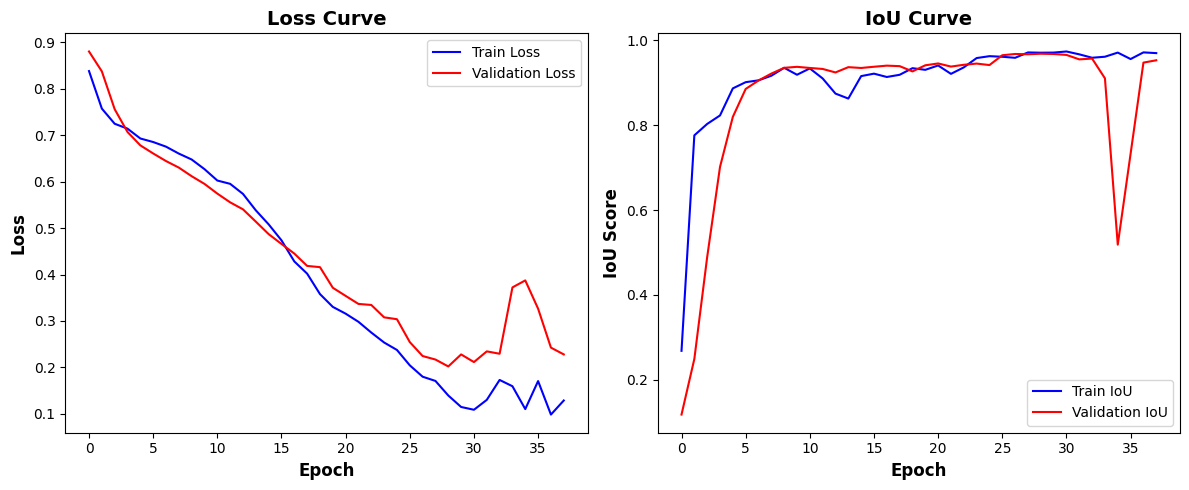

In [37]:
loss_and_metric_plot(RESULTS)


In [38]:
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm

def load_best_model(model_path: str):
    """Load the best trained model from a checkpoint."""

    checkpoint = torch.load(model_path, map_location=DEVICE)

    # Initialize model with same architecture
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, classes=5)
    model.load_state_dict(checkpoint)
    model.to(DEVICE)
    model.eval()  # Set to evaluation mode

    return model

# Set correct path for Colab
BEST_MODEL_PATH = "/content/best_model.pth"
model = load_best_model(BEST_MODEL_PATH)


<ipython-input-38-c60e05903a79>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)


In [40]:
test_transforms = A.Compose([
    A.Resize(*RESIZE),
    A.Normalize(),
    ToTensorV2()
])

test_dataset = RoadSegmentationDataset(test_data, color2id, test_transforms)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())

print(f"Loaded {len(test_dataset)} test samples.")

Loaded 5 test samples.


In [41]:
def predictions(test_dataloader, model):
    """Generate predictions for the test dataset."""

    pred_mask_test = []

    with torch.no_grad():  # Ensure no gradients are computed
        for X, _ in tqdm(test_dataloader, desc="Predicting"):
            X = X.to(DEVICE, dtype=torch.float32)
            logit_mask = model(X)
            prob_mask = logit_mask.softmax(dim=1)
            pred_mask = prob_mask.argmax(dim=1)  # Convert probabilities to class indices
            pred_mask_test.append(pred_mask.detach().cpu())

    pred_mask_test = torch.cat(pred_mask_test)

    return pred_mask_test

# Run predictions
pred_mask_test = predictions(test_dataloader, model)
print(f"Generated {pred_mask_test.shape[0]} predicted masks.")


Predicting: 100%|██████████| 1/1 [00:13<00:00, 13.03s/it]

Generated 5 predicted masks.


In [42]:
IMAGE_TEST = []
MASK_TEST = []

for img, mask in test_dataloader:
    IMAGE_TEST.append(img)
    MASK_TEST.append(mask)

IMAGE_TEST = torch.cat(IMAGE_TEST)
MASK_TEST = torch.cat(MASK_TEST)

print(f"Test Images Shape: {IMAGE_TEST.shape}, Test Masks Shape: {MASK_TEST.shape}")


Test Images Shape: torch.Size([5, 3, 512, 512]), Test Masks Shape: torch.Size([5, 512, 512])


In [46]:
# Ensure masks are in correct format for metric calculation
TP, FP, FN, TN = smp.metrics.get_stats(output=pred_mask_test.long(),
                                       target=MASK_TEST.long(),
                                       mode="multiclass",
                                       ignore_index=-1,
                                       num_classes=5)

iou_test = smp.metrics.iou_score(TP, FP, FN, TN, reduction="micro")
print(f" IoU Score on Test Set: {iou_test:.4f}")


 IoU Score on Test Set: 0.9691


In [44]:
# Define color mapping for visualization
id2color = {
    0: (184, 61, 245),  # Background
    1: (255, 53, 94),   # Road Sign
    2: (255, 204, 51),  # Car
    3: (221, 255, 51),  # Marking
    4: (61, 61, 245)    # Road Surface
}

def convert_mask_to_color(mask_tensor):
    """Convert class index mask to RGB color mask."""
    height, width = mask_tensor.shape
    color_mask = torch.zeros((height, width, 3), dtype=torch.uint8)

    for h in range(height):
        for w in range(width):
            class_id = int(mask_tensor[h, w])
            if class_id in id2color:
                color_mask[h, w, :] = torch.tensor(id2color[class_id])

    return color_mask

# Convert predicted masks
total_mask_output = [convert_mask_to_color(mask) for mask in pred_mask_test]

# Convert ground truth masks
total_mask_test = [convert_mask_to_color(mask) for mask in MASK_TEST]


In [47]:
total_mask_output = []

for i, mask_pred in enumerate(pred_mask_test):
    height, width = mask_pred.shape  # Extract dimensions

    # Filter out values of -1 (ignored class)
    mask_original = MASK_TEST[i]
    ignore = mask_original == -1

    mask_predicted = torch.where(ignore, -1, mask_pred)  # Assign -1 to ignored pixels
    mask_zeros = torch.zeros(size=(height, width, 3), dtype=torch.uint8)

    for h in range(height):
        for w in range(width):
            idcolor = int(mask_predicted[h, w])
            if idcolor in id2color:
                mask_zeros[h, w, :] = torch.tensor(id2color[idcolor])

    total_mask_output.append(mask_zeros)


In [48]:
total_mask_test = []

for mask_tst in MASK_TEST:
    height, width = mask_tst.shape  # Extract dimensions
    mask_zeros = torch.zeros(size=(height, width, 3), dtype=torch.uint8)

    for h in range(height):
        for w in range(width):
            idcolor = int(mask_tst[h, w])
            if idcolor in id2color:
                mask_zeros[h, w, :] = torch.tensor(id2color[idcolor])

    total_mask_test.append(mask_zeros)


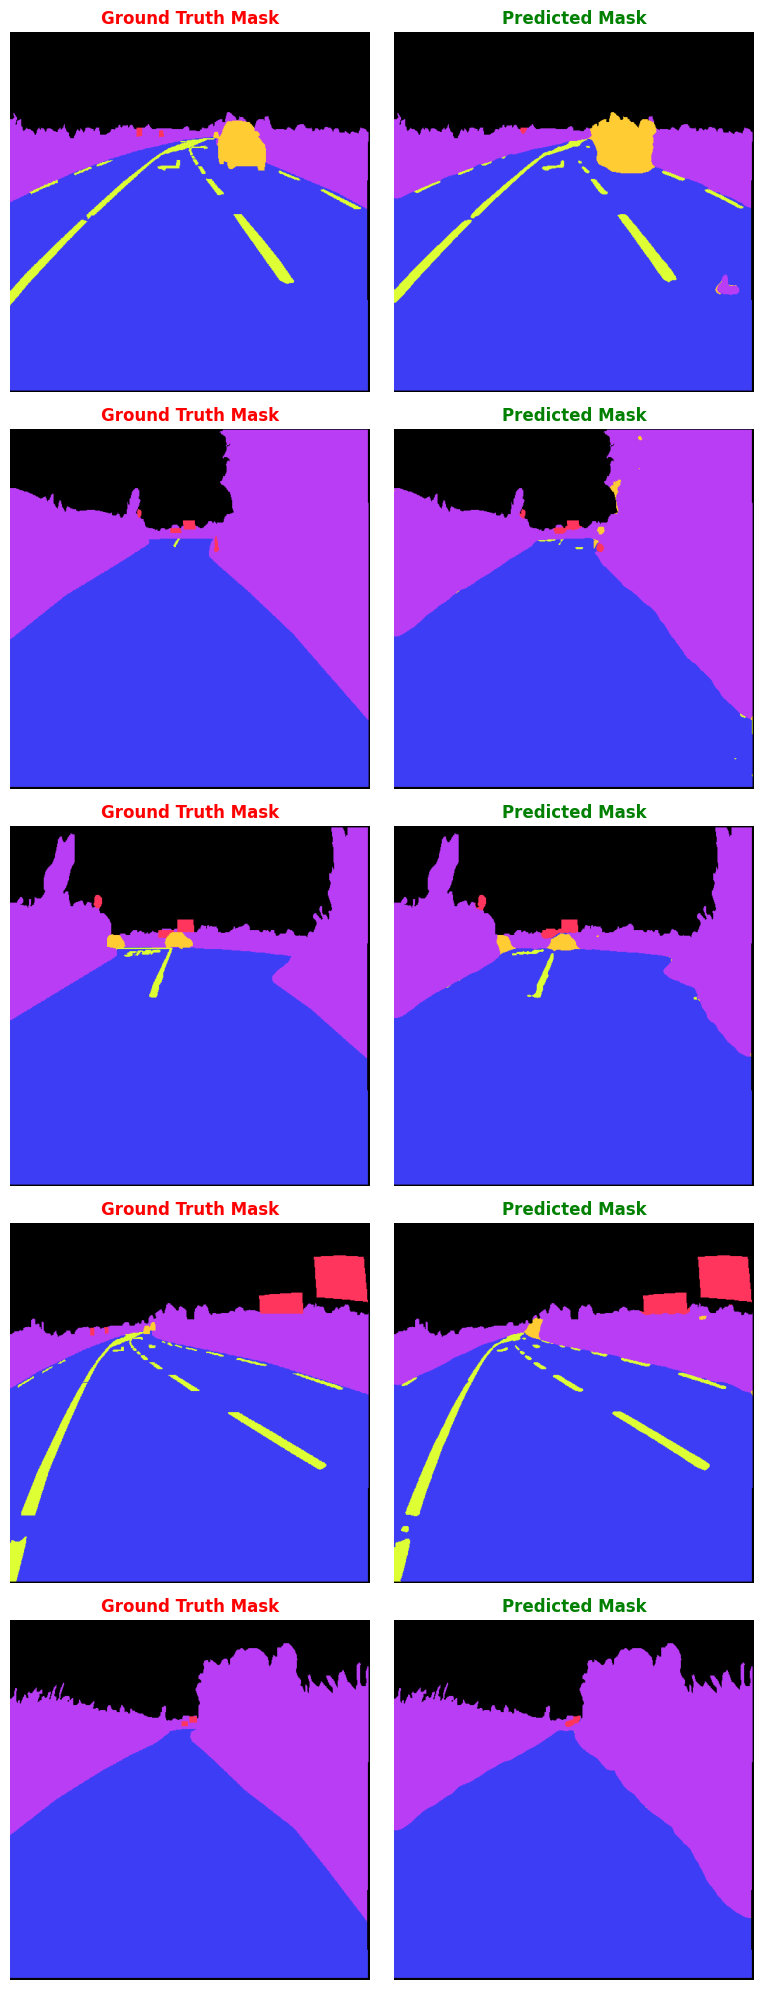

In [49]:
import matplotlib.pyplot as plt

# Set number of samples to visualize
NUM_SAMPLES = min(5, len(total_mask_output))

fig, ax = plt.subplots(nrows=NUM_SAMPLES, ncols=2, figsize=(8, 20))

for i in range(NUM_SAMPLES):
    # Ground Truth Mask
    mask_test = total_mask_test[i].numpy()
    ax[i, 0].imshow(mask_test)
    ax[i, 0].set_title("Ground Truth Mask", fontsize=12, fontweight="bold", color="red")
    ax[i, 0].axis("off")

    # Predicted Mask
    mask_pred = total_mask_output[i].numpy()
    ax[i, 1].imshow(mask_pred)
    ax[i, 1].set_title("Predicted Mask", fontsize=12, fontweight="bold", color="green")
    ax[i, 1].axis("off")

fig.tight_layout()
plt.show()


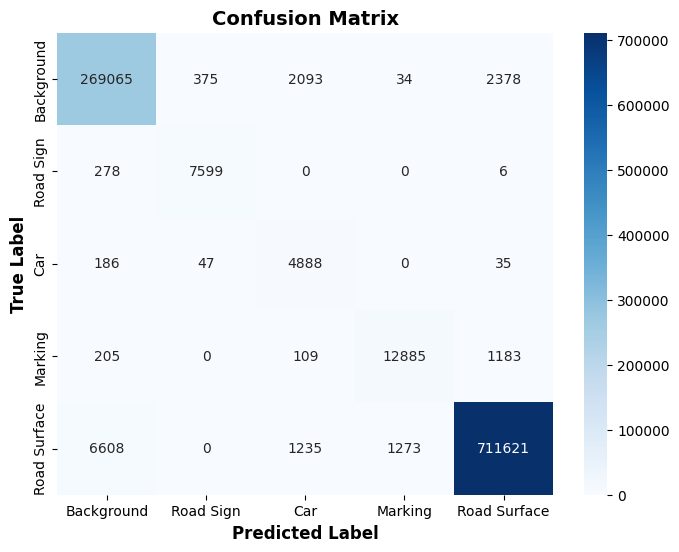

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(pred_masks, true_masks, class_names):
    """Generate & plot confusion matrix for segmentation classes."""
    pred_flat = pred_masks.view(-1).cpu().numpy()  # Flatten tensors
    true_flat = true_masks.view(-1).cpu().numpy()

    cm = confusion_matrix(true_flat, pred_flat, labels=np.arange(len(class_names)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
    plt.ylabel("True Label", fontsize=12, fontweight="bold")
    plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
    plt.show()

# Call function
plot_confusion_matrix(pred_mask_test, MASK_TEST, class_names)


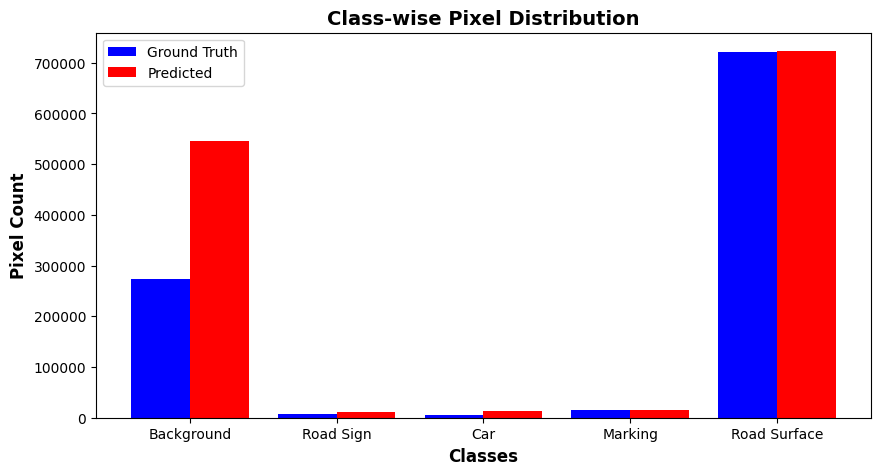

In [54]:
def plot_pixel_distribution(pred_masks, true_masks, num_classes, class_names):
    """Show pixel distribution per class in ground truth vs. predictions."""
    true_counts = [torch.sum(true_masks == i).item() for i in range(num_classes)]
    pred_counts = [torch.sum(pred_masks == i).item() for i in range(num_classes)]

    x = np.arange(len(class_names))

    plt.figure(figsize=(10, 5))
    plt.bar(x - 0.2, true_counts, width=0.4, label="Ground Truth", color="blue")
    plt.bar(x + 0.2, pred_counts, width=0.4, label="Predicted", color="red")

    plt.xticks(ticks=x, labels=class_names)
    plt.xlabel("Classes", fontsize=12, fontweight="bold")
    plt.ylabel("Pixel Count", fontsize=12, fontweight="bold")
    plt.title("Class-wise Pixel Distribution", fontsize=14, fontweight="bold")
    plt.legend()
    plt.show()

# Call function
plot_pixel_distribution(pred_mask_test, MASK_TEST, num_classes=5, class_names=class_names)


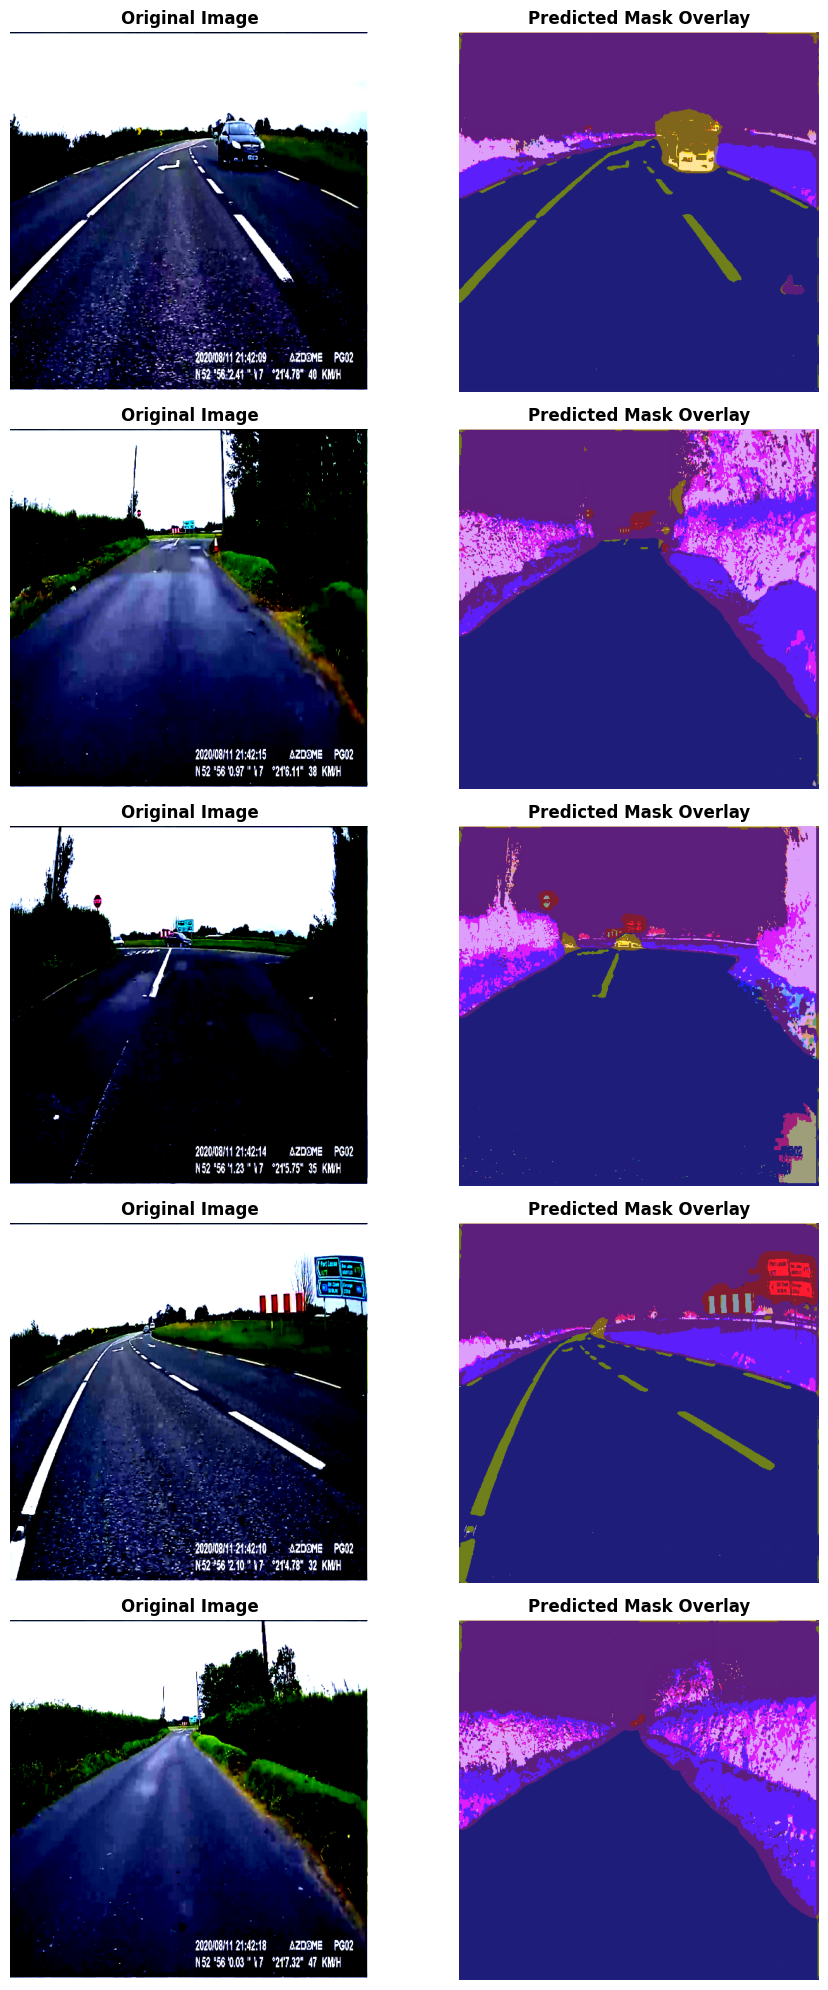

In [57]:
import cv2

def overlay_predictions(image, pred_mask, alpha=0.5):
    """Overlay segmentation predictions on input image."""
    image = image.permute(1, 2, 0).cpu().numpy()  # Convert tensor to NumPy (H, W, C)
    overlay = convert_mask_to_color(pred_mask).numpy()  # Convert mask to RGB

    overlayed_img = cv2.addWeighted(image.astype(np.uint8), 1 - alpha, overlay.astype(np.uint8), alpha, 0)

    return overlayed_img

# Plot overlays for sample images
NUM_SAMPLES = 5
fig, ax = plt.subplots(nrows=NUM_SAMPLES, ncols=2, figsize=(10, 20))

for i in range(NUM_SAMPLES):
    original_img = IMAGE_TEST[i]  # Input Image
    pred_mask = pred_mask_test[i]  # Predicted Mask

    overlayed_image = overlay_predictions(original_img, pred_mask)

    ax[i, 0].imshow(original_img.permute(1, 2, 0).cpu().numpy())  # Original Image
    ax[i, 0].set_title("Original Image", fontsize=12, fontweight="bold")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(overlayed_image)  # Overlayed Prediction
    ax[i, 1].set_title("Predicted Mask Overlay", fontsize=12, fontweight="bold")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()
